<a href="https://colab.research.google.com/github/ekourkchi/incNET-data/blob/master/VGG16_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from sklearn.model_selection import train_test_split

# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
data = np.load('/content/drive/My Drive/data_64x64.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

In [17]:
ix, = np.where(labels_[1]>50)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, labels_c, pgcIDs_c, test_size=0.40)

notUnique = np.isin(pgcIDs_test, pgcIDs_train)
Unique = np.logical_not(notUnique)

images_train = np.concatenate((images_train, images_test[notUnique]))
labels_train  = np.concatenate((labels_train, labels_test[notUnique]))
pgcIDs_train = np.concatenate((pgcIDs_train, pgcIDs_test[notUnique]))

images_test = images_test[Unique]
labels_test = labels_test[Unique]
pgcIDs_test = pgcIDs_test[Unique]


In [79]:
print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)
print(pgcIDs_train.shape)
print(pgcIDs_test.shape)

(42008, 64, 64, 3)
(1016, 64, 64, 3)
(42008,)
(1016,)
(42008,)
(1016,)


In [80]:
# labels_train  = labels_train - 51
# labels_test   = labels_test - 51
# images_test   = images_test / 255.
# images_train  = images_train / 255.

In [81]:
from keras import applications

from keras.models import Model
import keras

MODEL = applications.VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
MODEL.trainable = True

for layer in MODEL.layers[:-2]:
    layer.trainable = False


In [86]:
import pandas as pd
layers = [(layer, layer.name, layer.trainable) for layer in MODEL.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(18)

,Layer Type,Layer Name,Layer Trainable
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False
10,<tensorflow.python.keras.layers.pooling.MaxPoo...,block3_pool,False


In [87]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization
from keras.models import Sequential
from keras import optimizers

model = Sequential()

# for layer in MODEL.layers[:-4]: # just exclude last layer from copying
#   model.add(layer)
model.add(MODEL)

# model.add(Conv2D(512, (1, 1), activation='relu'))
# model.add(BatchNormalization(axis = 3))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.20))

model.add(Flatten())




# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))

# if it's a classification problem
# model.add(Dense(40, activation='softmax'))

# output layer
model.add(Dense(1, name='fc_out'))


model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 129       
Total params: 14,977,089
Trainable params: 2,622,209
Non-trainable params: 12,354,880
_________________________________________________________________


In [88]:
import keras.backend as K


# sparse_categorical_crossentropy
model.compile(loss = 'mae', optimizer='adam', metrics=['mse', 'mae'])
n_epochs = 30
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
fc_out (Dense)               (None, 1)                 129       
Total params: 14,977,089
Trainable params: 2,622,209
Non-trainable params: 12,354,880
_________________________________________________________________


In [89]:
model_history = model.fit(images_train, labels_train, 
                                  epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_data=(images_test, labels_test),
                                  shuffle=True)

Epoch 1/30
83/83 - 7s - loss: 12.4057 - mse: 321.2894 - mae: 12.4057 - val_loss: 7.1185 - val_mse: 77.3204 - val_mae: 7.1185
Epoch 2/30
83/83 - 7s - loss: 7.5461 - mse: 92.0562 - mae: 7.5461 - val_loss: 7.4023 - val_mse: 88.9376 - val_mae: 7.4023
Epoch 3/30
83/83 - 7s - loss: 7.1597 - mse: 84.5521 - mae: 7.1597 - val_loss: 5.8846 - val_mse: 58.0513 - val_mae: 5.8846
Epoch 4/30
83/83 - 7s - loss: 6.8316 - mse: 75.4261 - mae: 6.8316 - val_loss: 10.2869 - val_mse: 151.7037 - val_mae: 10.2869
Epoch 5/30
83/83 - 7s - loss: 6.8871 - mse: 76.4287 - mae: 6.8871 - val_loss: 5.4848 - val_mse: 53.3461 - val_mae: 5.4848
Epoch 6/30
83/83 - 7s - loss: 6.5228 - mse: 68.9843 - mae: 6.5228 - val_loss: 5.4858 - val_mse: 52.2497 - val_mae: 5.4858
Epoch 7/30
83/83 - 7s - loss: 6.4636 - mse: 67.4364 - mae: 6.4636 - val_loss: 6.0009 - val_mse: 60.9099 - val_mae: 6.0009
Epoch 8/30
83/83 - 7s - loss: 6.5003 - mse: 68.3362 - mae: 6.5003 - val_loss: 5.5131 - val_mse: 51.7005 - val_mae: 5.5131
Epoch 9/30
83/83 -

loss
mse
mae
val_loss
val_mse
val_mae


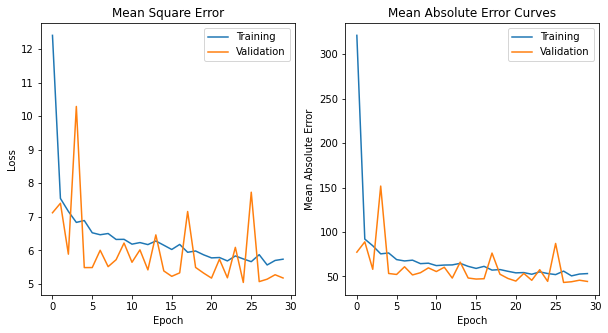

In [90]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['mse']
    val_acc = history.history['val_mse']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation')
    ax[0].set_title('Mean Square Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation')
    ax[1].set_title('Mean Absolute Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Absolute Error')
    
# plot the training history
for key in model.history.history:
  print(key)

plot_model_history(model.history)

In [91]:
# inc_p = model.predict(images_test)
# inc_m = labels_test +51


# N = images_test.shape[0]

# inc_p = np.argmax(inc_p, axis=1) + 51

inc_p = model.predict(images_test)
inc_m = labels_test


N = images_test.shape[0]
inc_p = inc_p.reshape(N)

6.662124362724922
6.394358938759013


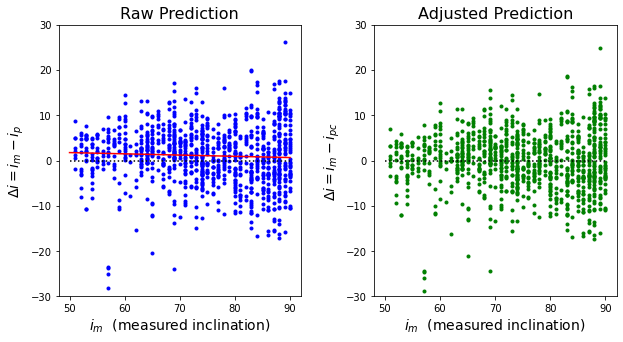

In [92]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print(np.sqrt(np.mean((d)**2)))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print(np.sqrt(np.mean((d_)**2)))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

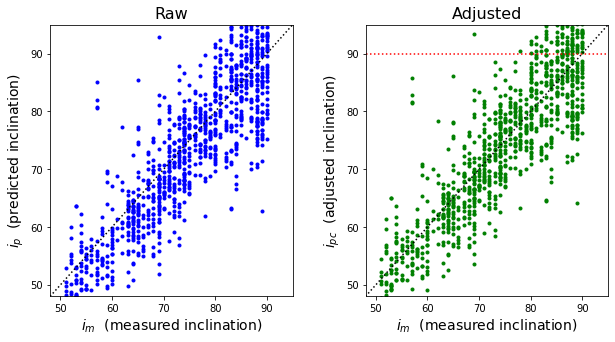

In [93]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, 'b.')
ax[0].plot([48,95],[48,95], 'k:')
ax[0].set_xlim(48,95)
ax[0].set_ylim(48,95)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([48,95],[48,95], 'k:')
ax[1].set_xlim(48,95)
ax[1].set_ylim(48,95)
ax[1].plot([48,95],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)